Load Databases From Kaggle and Clean Them

In [52]:
import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset_name_all_seasons = 'justinas/nba-players-data'
dataset_name_nba_draft_players = 'mattop/nba-draft-basketball-player-data-19892021'

def download_dataset(dataset_name, save_path):
    api.dataset_download_files(dataset_name, path=save_path, unzip=True)

download_dir = "./kaggle_datasets"
os.makedirs(download_dir, exist_ok=True)

download_dataset(dataset_name_all_seasons, download_dir)
download_dataset(dataset_name_nba_draft_players, download_dir)

# Load and clean all_seasons dataset
all_seasons_file = os.path.join(download_dir, 'all_seasons.csv')  
df_all_seasons = pd.read_csv(all_seasons_file)


df_all_seasons = df_all_seasons[df_all_seasons['college'].notna() & (df_all_seasons['college'] != 'None')]

columns_to_check = ['draft_year', 'draft_round', 'draft_number']
for col in columns_to_check:
    df_all_seasons = df_all_seasons[df_all_seasons[col] != 'Undrafted']

# Save cleaned all_seasons dataset
cleaned_all_seasons_file = os.path.join(download_dir, "all_seasons_cleaned.csv")
df_all_seasons.to_csv(cleaned_all_seasons_file, index=False)

# Load and clean nba_draft dataset
nba_draft_file = os.path.join(download_dir, 'nbaplayersdraft.csv') 
df_nba_draft = pd.read_csv(nba_draft_file)


df_nba_draft = df_nba_draft.rename(columns={'player': 'player_name'})

# Drop rows with missing values in the nba_draft dataset
df_nba_draft_cleaned = df_nba_draft.dropna()

# Save cleaned nba_draft dataset
cleaned_nba_draft_file = os.path.join(download_dir, "nbadraftplayers_cleaned.csv")
df_nba_draft_cleaned.to_csv(cleaned_nba_draft_file, index=False)


print("All Seasons Dataset - Cleaned:")
print(df_all_seasons.head())

print("NBA Draft Players Dataset - Cleaned:")
print(df_nba_draft_cleaned.head())



Dataset URL: https://www.kaggle.com/datasets/justinas/nba-players-data
Dataset URL: https://www.kaggle.com/datasets/mattop/nba-draft-basketball-player-data-19892021
All Seasons Dataset - Cleaned:
   Unnamed: 0       player_name team_abbreviation   age  player_height  \
0           0  Randy Livingston               HOU  22.0         193.04   
1           1  Gaylon Nickerson               WAS  28.0         190.50   
2           2      George Lynch               VAN  26.0         203.20   
3           3    George McCloud               LAL  30.0         203.20   
4           4      George Zidek               DEN  23.0         213.36   

   player_weight                college country draft_year draft_round  ...  \
0      94.800728        Louisiana State     USA       1996           2  ...   
1      86.182480  Northwestern Oklahoma     USA       1994           2  ...   
2     103.418976         North Carolina     USA       1993           1  ...   
3     102.058200          Florida State    

Combine Datasets 

In [53]:
# Load the datasets
all_seasons = pd.read_csv("kaggle_datasets/all_seasons_cleaned.csv")
nbadraftplayers = pd.read_csv("kaggle_datasets/nbadraftplayers_cleaned.csv")

# Merge the datasets on the player_name column and only keep the players that are matching
nba_stats_df = pd.merge(all_seasons, nbadraftplayers, on="player_name", how="inner") 

# Save the combined dataset to a CSV file
combined_file_path = os.path.join(download_dir, "combined_nba_data.csv")
nba_stats_df.to_csv(combined_file_path, index=False)


print(nba_stats_df.head())


   Unnamed: 0       player_name team_abbreviation   age  player_height  \
0           0  Randy Livingston               HOU  22.0         193.04   
1           1  Gaylon Nickerson               WAS  28.0         190.50   
2           2      George Lynch               VAN  26.0         203.20   
3           3    George McCloud               LAL  30.0         203.20   
4           7         Glen Rice               CHH  30.0         203.20   

   player_weight              college_x country  draft_year  draft_round  ...  \
0      94.800728        Louisiana State     USA        1996            2  ...   
1      86.182480  Northwestern Oklahoma     USA        1994            2  ...   
2     103.418976         North Carolina     USA        1993            1  ...   
3     102.058200          Florida State     USA        1989            1  ...   
4      99.790240               Michigan     USA        1989            1  ...   

   3_point_percentage  free_throw_percentage  average_minutes_played

Visualizations

In [54]:
pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


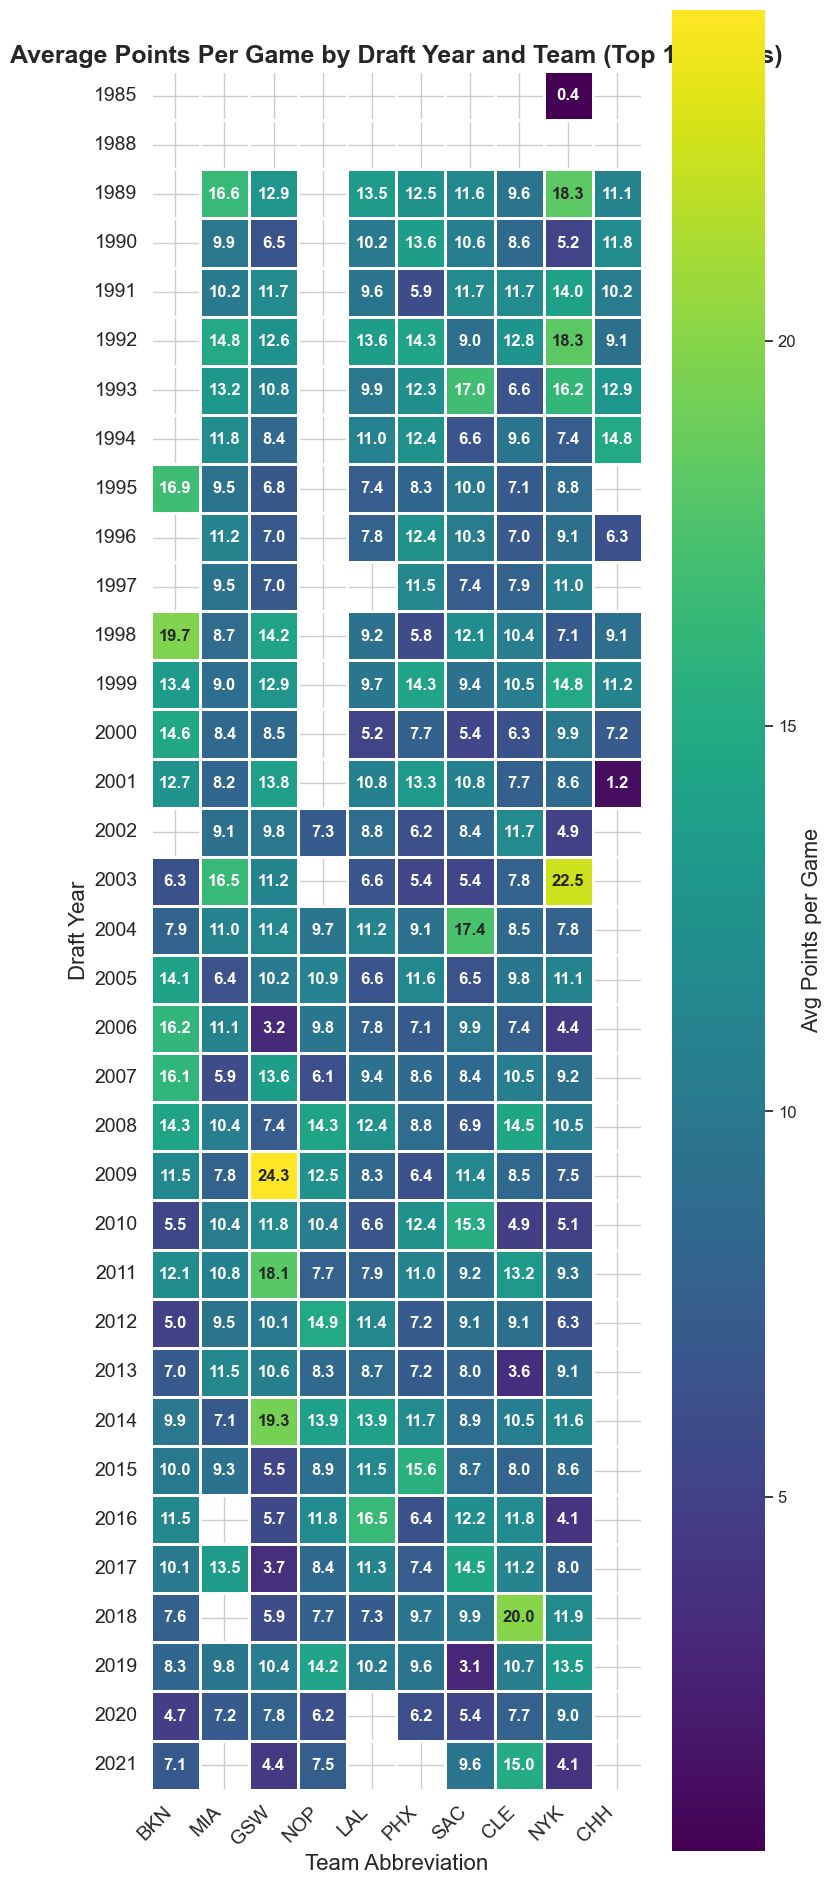

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pivot table of average points per game by draft year and team
draft_team_pivot = nba_stats_df.pivot_table(values='points_per_game', index='draft_year', columns='team_abbreviation', aggfunc='mean')

# Focus on the top teams based on average points per game
top_teams = draft_team_pivot.mean().sort_values(ascending=False).head(10).index 
draft_team_pivot = draft_team_pivot[top_teams]


plt.figure(figsize=(8, 30)) 
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

# Create heatmap
heatmap = sns.heatmap(draft_team_pivot, cmap='viridis', annot=True, fmt='.1f', linewidths=1, cbar_kws={'label': 'Avg Points per Game'}, 
                      annot_kws={'size': 12, 'weight': 'bold'}, square=True)

# Title and labels
plt.title('Average Points Per Game by Draft Year and Team (Top 10 Teams)', fontsize=18, fontweight='bold')
plt.xlabel('Team Abbreviation', fontsize=16)
plt.ylabel('Draft Year', fontsize=16)

# Readable titles
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)

plt.tight_layout()

plt.show()



This heatmap will help you see trends in player performance by team over different years, indicating which teams have historically drafted well and which have struggled.

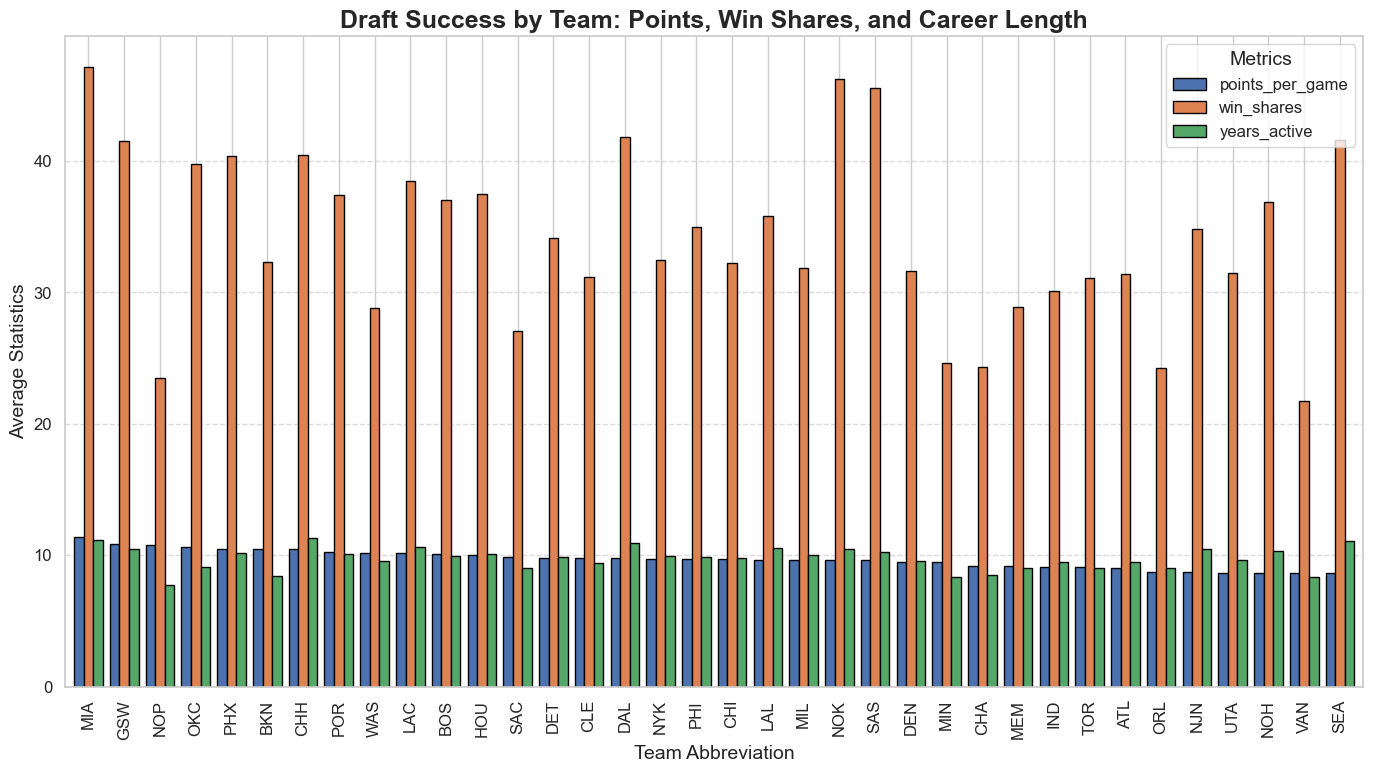

In [56]:
# Calculate average career statistics by team
team_draft_success = nba_stats_df.groupby('team_abbreviation').agg({
    'points_per_game': 'mean',
    'win_shares': 'mean',
    'years_active': 'mean'
}).sort_values(by='points_per_game', ascending=False)

# Plot the data 
plt.figure(figsize=(14, 8))  
sns.set_style('whitegrid')  
team_draft_success[['points_per_game', 'win_shares', 'years_active']].plot(kind='bar', width=0.8, edgecolor='black', ax=plt.gca())

# Title and labels
plt.title('Draft Success by Team: Points, Win Shares, and Career Length', fontsize=18, fontweight='bold')
plt.xlabel('Team Abbreviation', fontsize=14)
plt.ylabel('Average Statistics', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='Metrics', fontsize=12, title_fontsize=14)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()


This visualization will provide a multi-metric comparison of teams' draft success, showing the relationship between points, win shares, and the career length of players drafted by each team.

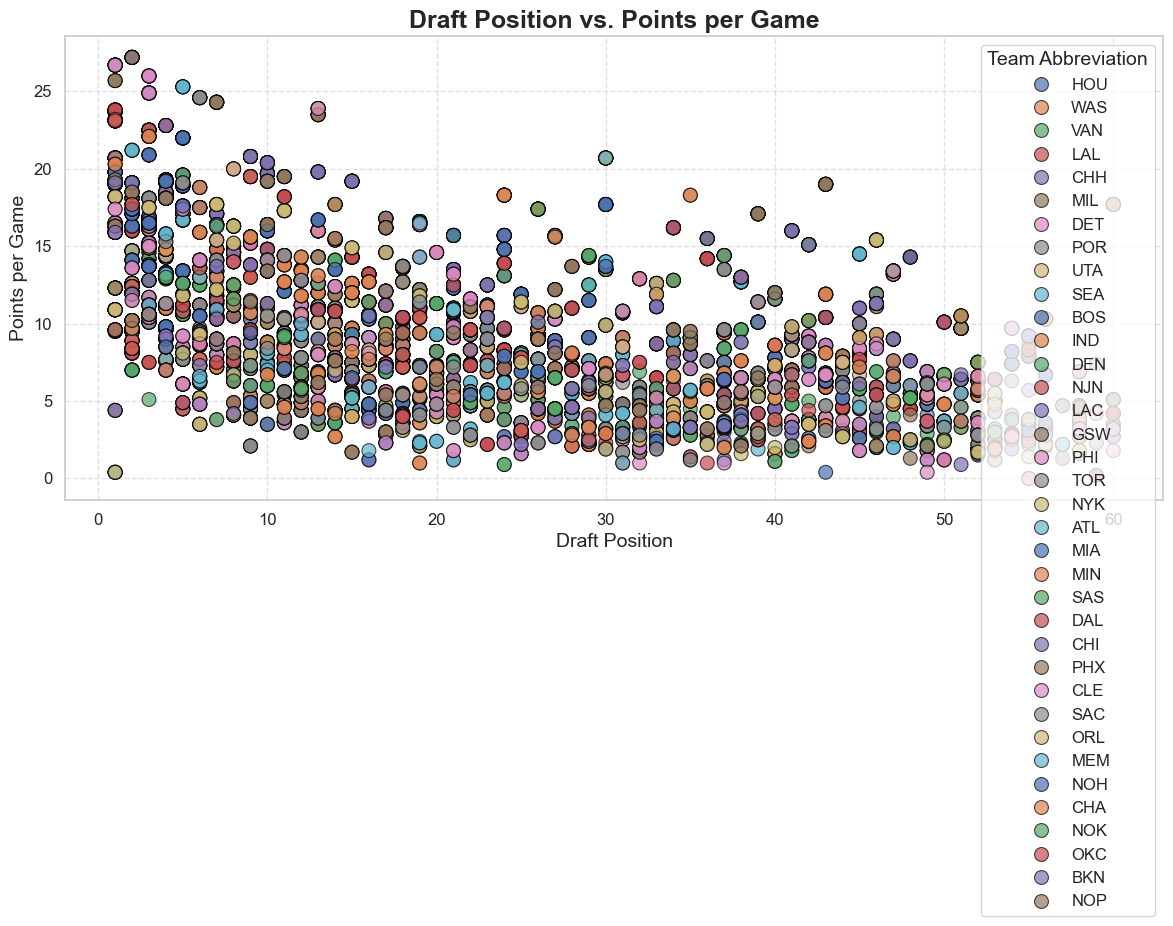

In [57]:
plt.figure(figsize=(12, 8))  

# Scatter plot
sns.scatterplot(data=nba_stats_df, x='draft_number', y='points_per_game', hue='team_abbreviation', 
                palette='deep', s=100, edgecolor='black', alpha=0.7)

# Title and labels
plt.title('Draft Position vs. Points per Game', fontsize=18, fontweight='bold')
plt.xlabel('Draft Position', fontsize=14)
plt.ylabel('Points per Game', fontsize=14)

plt.legend(title='Team Abbreviation', title_fontsize=14, loc='upper right', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  
plt.show()


This scatter plot will show the relationship between a player’s draft position and their performance in terms of points per game, with different colors for each team.

C:\Users\tiffa\AppData\Local\Temp\ipykernel_16196\4251117021.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=nba_stats_df, x='draft_round', y='points_per_game', palette='muted', width=0.6)


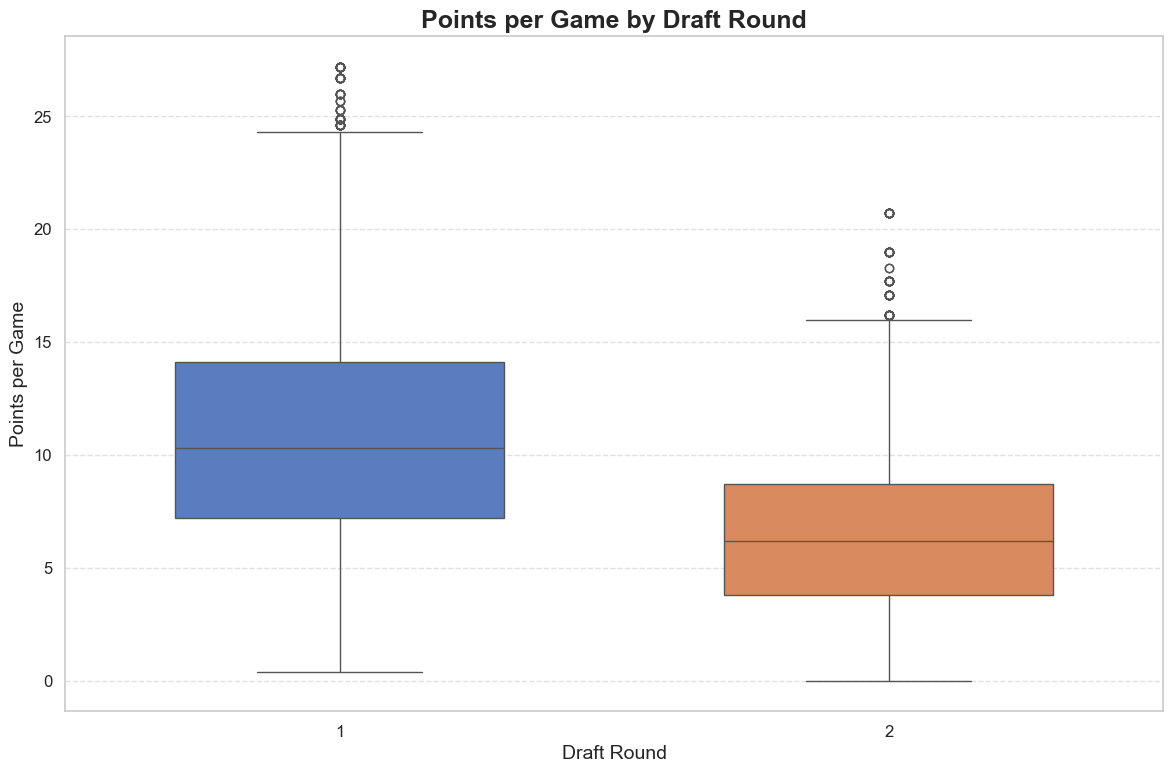

In [58]:
# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=nba_stats_df, x='draft_round', y='points_per_game', palette='muted', width=0.6)

# Title and labels
plt.title('Points per Game by Draft Round', fontsize=18, fontweight='bold')
plt.xlabel('Draft Round', fontsize=14)
plt.ylabel('Points per Game', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6, axis='y')

plt.tight_layout()

plt.show()


This boxplot will allow you to compare how well first-round picks are performing relative to second-round and undrafted players

In [59]:
pip install adjustText


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


7 [ 0.39689588 -0.76906536]
14 [-0.3283384  0.7558397]
0 [-0.94546686  0.90958428]
2 [-0.23472655 -0.04535515]
8 [-0.59058014 -0.41373575]
29 [-0.50033896  0.52717125]
17 [ 0.08371907 -0.80553822]
23 [ 0.11933382 -0.84907583]


C:\Users\tiffa\AppData\Local\Temp\ipykernel_16196\363668281.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


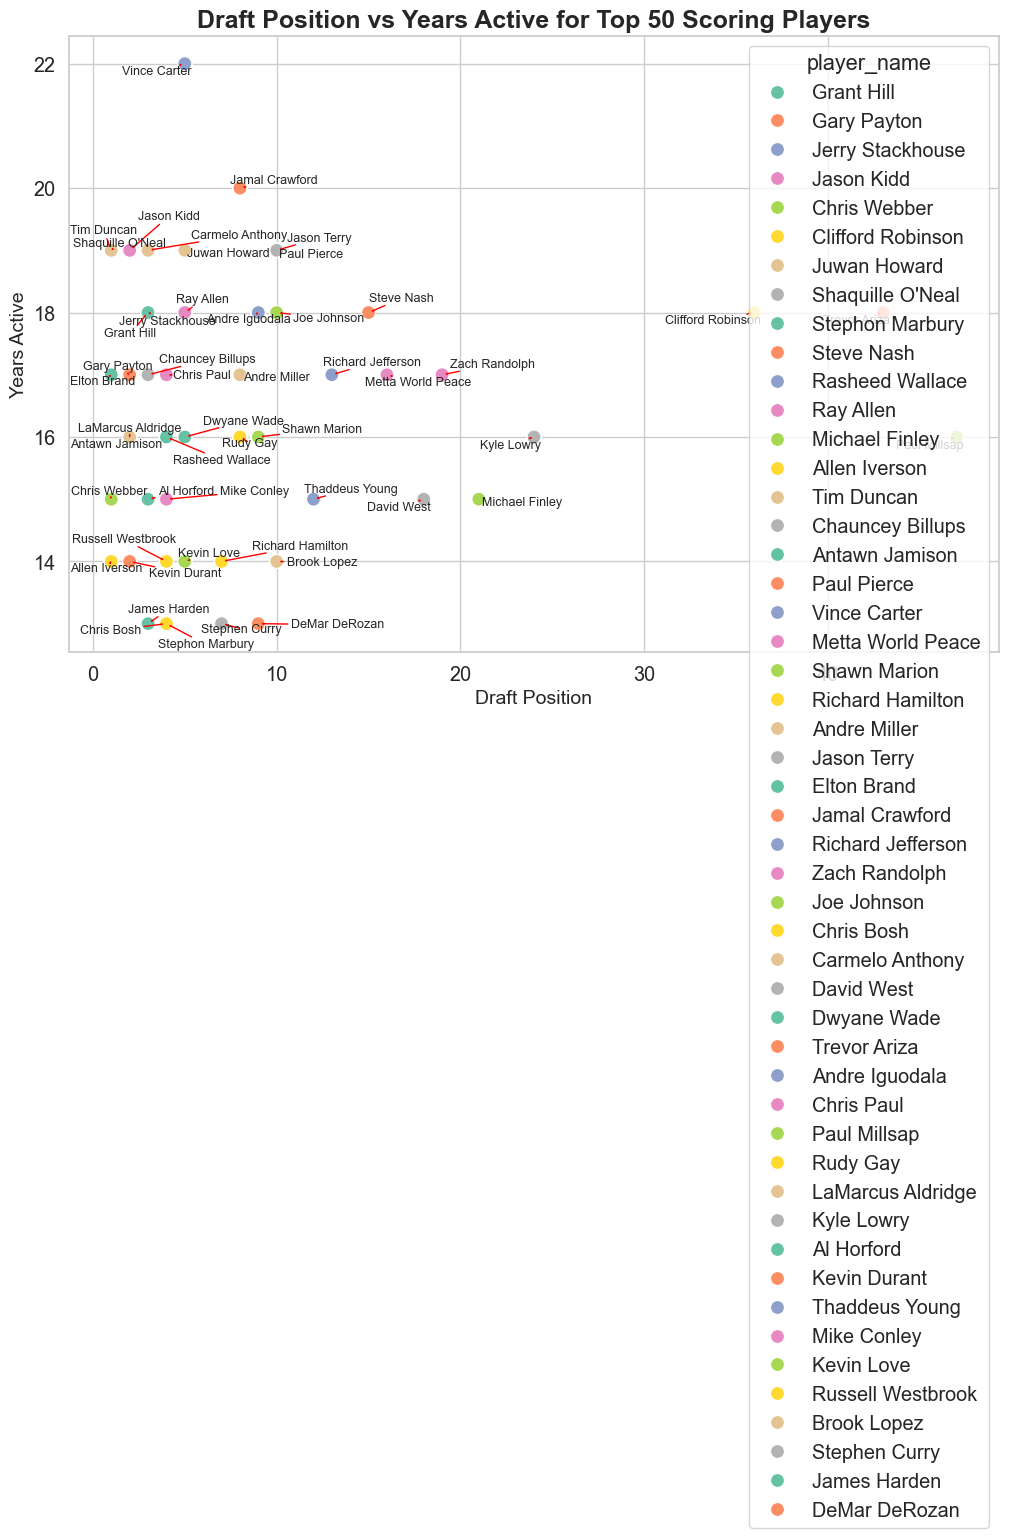

In [60]:
from adjustText import adjust_text

# Calculate the total points scored for each player
top_50_players = nba_stats_df.groupby('player_name')['points'].sum().sort_values(ascending=False).head(50).index

# Filter data for the top 50 scoring players
top_50_players_data = nba_stats_df[nba_stats_df['player_name'].isin(top_50_players)]

# Create a scatter plot
plt.figure(figsize=(12, 8))

sns.scatterplot(data=top_50_players_data, x='draft_number', y='years_active', hue='player_name', palette='Set2', marker='o', s=100)

texts = []
for i, player in enumerate(top_50_players_data['player_name'].unique()):
    player_data = top_50_players_data[top_50_players_data['player_name'] == player]
    
    # Add the player name to the list for annotation
    texts.append(plt.text(player_data['draft_number'].iloc[0], 
                          player_data['years_active'].iloc[0], 
                          player, fontsize=9, ha='center', va='center'))

adjust_text(texts, only_move='xy', arrowprops=dict(arrowstyle='->', color='red'))

# Title and labels
plt.title('Draft Position vs Years Active for Top 50 Scoring Players', fontsize=18, fontweight='bold')
plt.xlabel('Draft Position', fontsize=14)
plt.ylabel('Years Active', fontsize=14)

plt.tight_layout()

plt.show()





This scatter plot displays the relationship between draft position and years active for the top 50 NBA players by points scored. Each point represents a player, with player names annotated to show their respective draft positions and career lengths.